# Kaggle Competition - Solar PV in Aerial Imagery

## *Team 8: Pinkies*
Yuan Feng [yf115]\
Sebastián Soriano Pérez [ss1072]\
Vishaal Venkatesh [vv58]\
Abhiraj Vinnakota [agv9]\
Roderick Whang [rjw34]

## 1. Jupyter Notebook Setup

Importing all necessary packages and additional setups for this notebook to run properly.

In [1]:
'''
Import packages
'''
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
import cv2
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
import warnings
warnings.filterwarnings('ignore')
plt.close()

In [2]:
# For clearer plots in Jupyter notebooks on macs, run the following line of code:
%config InlineBackend.figure_format = 'retina'

In [3]:
'''
Set directory parameters
'''
# Set the directories for the data and the CSV files that contain ids/labels
dir_train_images  = '../data/training/'
dir_test_images   = '../data/testing/'
dir_train_labels  = '../data/labels_training.csv'
dir_test_ids      = '../data/sample_submission.csv'

## 2. Function Definition

Definition of every function needed to load the datasets, preprocess the data and extract features, define the classigication models, test the cross validated performance of the models, and plot the performance metrics.

In [4]:
def load_data(dir_data, dir_labels, training = True):
    '''
    Load each of the image files into memory
    
    When training = True, the labels are also loaded
    '''
    labels_pd = pd.read_csv(dir_labels)
    ids       = labels_pd.id.values
    data      = []
    
    for identifier in ids:
        fname     = dir_data + identifier.astype(str) + '.tif'
        image     = mpl.image.imread(fname)
        data.append(image)
        
    data = np.array(data) # Convert to Numpy array
    
    if training:
        labels = labels_pd.label.values
        return data, labels
    
    else:
        return data, ids

In [5]:
def preprocess_and_extract_features(data, prc):
    '''
    Preprocess data and extract features
    
    Preprocess: normalize, scale, repair
    Extract features: transformations and dimensionality reduction
    
    data: X matrix of images/features
    prc: string for selected features extraction process -> 'colors', 'HOG'
    '''
    if prc == 'color':
        # Filter images to keep only colors in the optimal range found at the end of this notebook
        
        color_lo = np.asarray([0, 0, 110])   # Lower color
        color_hi = np.asarray([55, 87, 187]) # Higher color
        new_data = []                        # Empty list with new features (average color values for RGB channels)
        
        for img in data:
            # Iterate over every image in set
            
            img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            mask = cv2.inRange(img_hsv, color_lo, color_hi) # Create mask of pixels that are inside the color range
            mask[mask != 0] = 1                             # Keep colors, turns every non black pixel into 1
            mask = np.expand_dims(mask, axis = 2)
            mask = np.append(
                np.append(mask, mask, axis = 2), 
                mask, 
                axis = 2
            )
            feature = img * mask                            # Turns every pixel outside the range into 0
            
            if np.count_nonzero(feature) != 0: 
                # Extract average color value on RGB channels for non-zero pixels
                
                feature = np.sum(np.sum(feature, axis = 0), axis = 0) / np.count_nonzero(feature)
                
            else:
                # If no color is inside range, sets average color values for RGB channels as 255 (white)
                
                feature = [255, 255, 255]

            new_data.append(feature)                        # Appends features to list
        
        features = np.array(new_data)

        return features
    
    elif prc == 'HOG':
        # Runs Histogram of Gradients feature extraction process to detect edges on images
        
        get_hog = lambda X: hog(X, orientations = 9, pixels_per_cell = (16, 16),
                                cells_per_block = (4, 4), visualize = False, multichannel = True)
        features = np.array([get_hog(image) for image in data])

        return features

In [6]:
def set_classifier(clf):
    '''
    Shared function to select the classifier for both performance evaluation and testing
    '''
    if clf == 'knn':
        return KNeighborsClassifier(n_neighbors = 7)
    
    elif clf == 'logistic':
        return LogisticRegression(solver = 'liblinear')

In [7]:
def cv_performance_assessment(X, y, k, clf, prc):
    '''
    Cross validated performance assessment
    
    X   = training data
    y   = training labels
    k   = number of folds for cross validation
    clf = classifier to use
    prc = feature extraction process
    
    Divide the training data into k folds of training and validation data. 
    For each fold the classifier will be trained on the training data and
    tested on the validation data. The classifier prediction scores are 
    aggregated and output
    '''
    # Establish the k folds
    
    prediction_scores = np.empty(y.shape[0], dtype = 'object')
    kf = StratifiedKFold(n_splits = k, shuffle = True)
    
    for train_index, val_index in kf.split(X, y):
        # Extract the training and validation data for this fold
        
        X_train_l, X_val = X[train_index], X[val_index]
        y_train_l        = y[train_index]
        
        # Train the classifier
        
        if prc != 'NA':
            X_train_features = preprocess_and_extract_features(X_train_l, prc)
        
        else:
            X_train_features = X_train_l
        
        clf = clf.fit(X_train_features, y_train_l)
        
        # Test the classifier on the validation data for this fold
        
        if prc != 'NA':
            X_val_features = preprocess_and_extract_features(X_val, prc)
        
        else:
            X_val_features = X_val
        
        cpred = clf.predict_proba(X_val_features)
        
        # Save the predictions for this fold
        
        prediction_scores[val_index] = cpred[:, 1]
        
    return prediction_scores

In [8]:
def plot_roc(labels, prediction_scores, legend, color):
    '''
    Function to plot ROC curve
    '''
    fpr, tpr, _   = metrics.roc_curve(labels, prediction_scores, pos_label = 1)
    auc           = metrics.roc_auc_score(labels, prediction_scores)
    legend_string = legend + ' (AUC = {:0.3f})'.format(auc)  
    plt.plot(fpr, tpr, label = legend_string, color = color)

In [9]:
def plot_prc(labels, prediction_scores, legend, color):
    '''
    Function to plot PRC curve
    '''
    precision, recall, thresholds = precision_recall_curve(labels, prediction_scores)
    average_precision = average_precision_score(labels, prediction_scores)
    legend_string = legend + ' (AP = {:0.3f})'.format(average_precision)  
    plt.plot(recall, precision, label = legend_string, color = color)

## 3. Model Fitting and Performance Cross Validation

Performance Cross validation for every model used.

In [10]:
'''
Loading data
'''
X_train, y_train = load_data(dir_train_images, dir_train_labels)
X_test, ids_test = load_data(dir_test_images, dir_test_ids, training = False)

In [11]:
'''
Model 1: Cross validated performance for Color Filtering method
'''
# Set parameters for the analysis
num_training_folds1 = 10
clf1 = set_classifier('knn')
prc1 = 'color'

# Perform cross validated performance assessment
prediction_scores1 = cv_performance_assessment(X_train, y_train, num_training_folds1, clf1, prc1)

In [12]:
'''
Model 2: Cross validated performance for HOG method
'''
# Set parameters for the analysis
num_training_folds2 = 10
clf2 = set_classifier('knn')
prc2 = 'HOG'

# Perform cross validated performance assessment
prediction_scores2 = cv_performance_assessment(X_train, y_train, num_training_folds2, clf2, prc2)

In [13]:
'''
Model 3: Cross validated performance for embedded model
'''
# Create training features Z with predictions scores from Model 1 and Model 2
Z_train = np.stack((prediction_scores1, prediction_scores2), axis = -1)

# Set parameters for the analysis
num_training_folds3 = 10
clf3 = set_classifier('logistic')
prc3 = 'NA'

# Perform cross validated performance assessment
prediction_scores3 = cv_performance_assessment(Z_train, y_train, num_training_folds3, clf3, prc3)

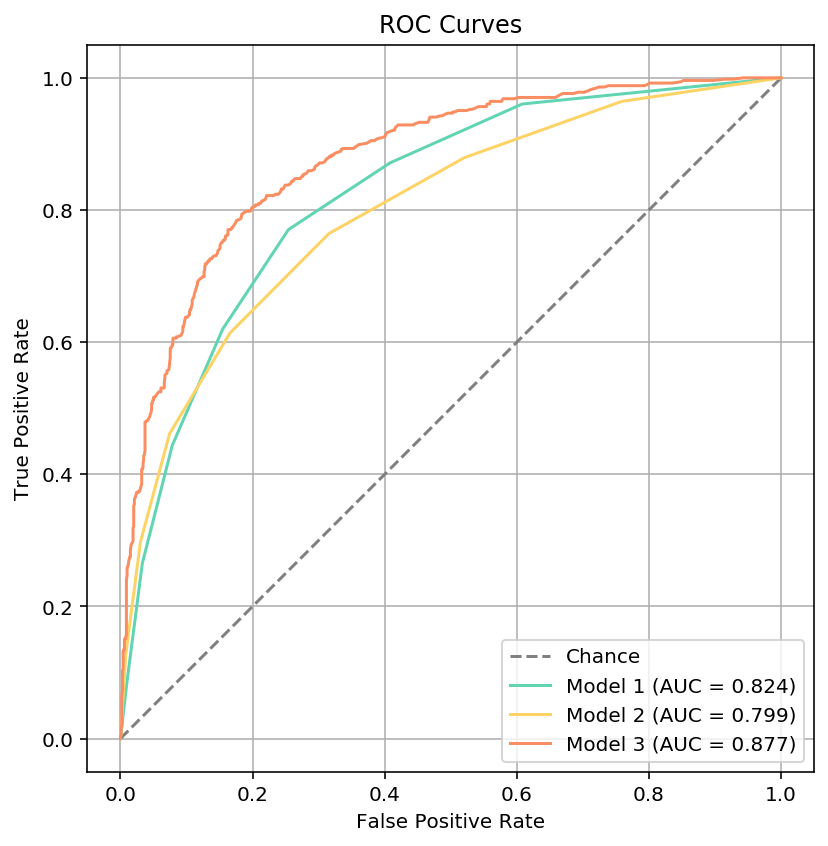

In [14]:
'''
Plotting ROC Curves
'''
# Compute and plot the ROC curves
plt.figure(figsize = (6, 6))
plt.title('ROC Curves')
plt.plot([0, 1], [0, 1], '--', color = 'gray', label = 'Chance')

# Plot ROC for each model
plot_roc(y_train, prediction_scores1, legend = 'Model 1', color = '#61d4b3')
plot_roc(y_train, prediction_scores2, legend = 'Model 2', color = '#fdd365')
plot_roc(y_train, prediction_scores3, legend = 'Model 3', color = '#fb8d62')
#plot_roc(y_train, prediction_scores4, legend = 'Model 4', color = '#fd2eb3')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid('on')
plt.axis('square')
plt.legend()
plt.tight_layout()

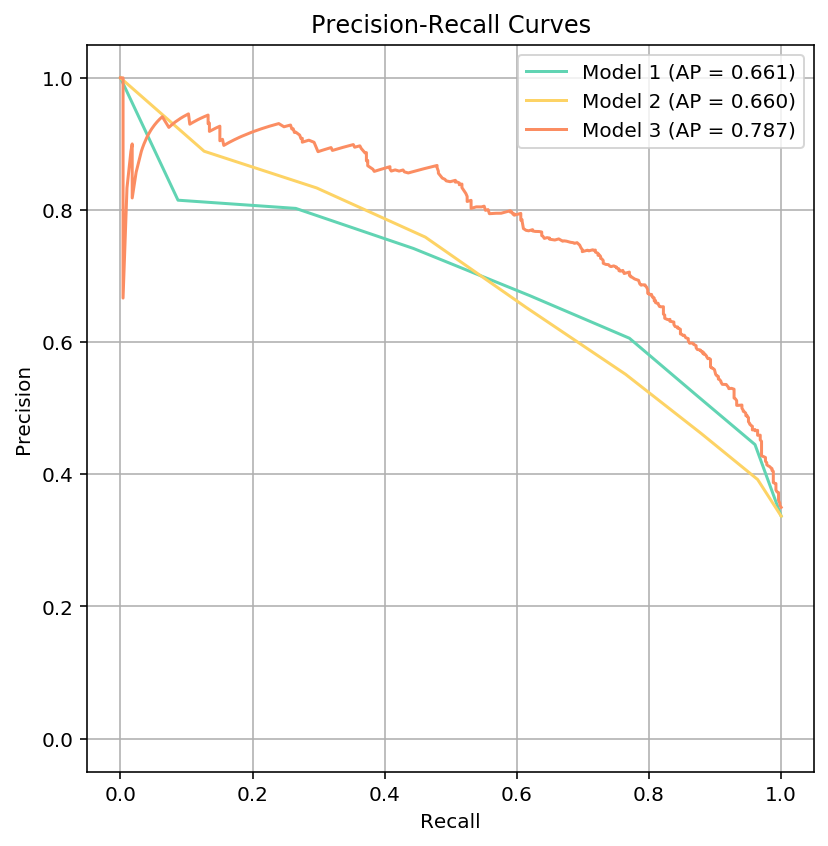

In [15]:
'''
Plotting PRC Curves
'''
# Compute and plot the PRC curves
plt.figure(figsize = (6, 6))
plt.title('Precision-Recall Curves')

# Plot ROC for each model
plot_prc(y_train, prediction_scores1, legend = 'Model 1', color = '#61d4b3')
plot_prc(y_train, prediction_scores2, legend = 'Model 2', color = '#fdd365')
plot_prc(y_train, prediction_scores3, legend = 'Model 3', color = '#fb8d62')
#plot_prc(y_train, prediction_scores4, legend = 'Model 4', color = '#fd2eb3')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid('on')
plt.axis('square')
plt.ylim(-0.05, 1.05)
plt.legend()
plt.tight_layout()

## 4. Kaggle Submissions

File creation for Kaggle submissions using test data predicted scores with every model trained on the full training dataset.

In [16]:
'''
Kaggle submission for Model 1
'''
# Load data, extract features, and train the classifier on the training data
training_features1 = preprocess_and_extract_features(X_train, prc1)
clf1.fit(training_features1, y_train)

# Load the test data and test the classifier
test_features1  = preprocess_and_extract_features(X_test, prc1)
test_scores1    = clf1.predict_proba(test_features1)[:, 1]

# Save the predictions to a CSV file for upload to Kaggle
submission_file = pd.DataFrame({'id':    ids_test,
                                'score': test_scores1})
submission_file.to_csv('../submission/submission1.csv',
                       columns = ['id', 'score'],
                       index = False)

In [17]:
'''
Kaggle submission for Model 2
'''
# Load data, extract features, and train the classifier on the training data
training_features2 = preprocess_and_extract_features(X_train, prc2)
clf2.fit(training_features2, y_train)

# Load the test data and test the classifier
test_features2  = preprocess_and_extract_features(X_test, prc2)
test_scores2    = clf2.predict_proba(test_features2)[:, 1]

# Save the predictions to a CSV file for upload to Kaggle
submission_file = pd.DataFrame({'id':    ids_test,
                                'score': test_scores2})
submission_file.to_csv('../submission/submission2.csv',
                       columns = ['id', 'score'],
                       index = False)

In [18]:
'''
Kaggle submission for Model 3
'''
# Load data, extract features, and train the classifier on the training data
training_features3 = Z_train
clf3.fit(training_features3, y_train)

# Load the test data and test the classifier
# Create test features Z with predictions scores from Model 1 and Model 2
Z_test = np.stack((test_scores1, test_scores2), axis = -1)
test_features3  = Z_test
test_scores3    = clf3.predict_proba(test_features3)[:, 1]

# Save the predictions to a CSV file for upload to Kaggle
submission_file = pd.DataFrame({'id':    ids_test,
                                'score': test_scores2})
submission_file.to_csv('../submission/submission3.csv',
                       columns = ['id', 'score'],
                       index = False)

## 4. Appendix

Code used to find the best values to filter the images for the color filtering method used for model 1.

In [117]:
def extract_colors(img, color_lo, color_hi):
    '''
    Function to test the color filtering method
    '''
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(img_hsv, color_lo, color_hi)
    #mask[mask == 0]  = 1 #filter out
    #mask[mask != 1]  = 0
    mask[mask != 0] = 1 #keep colors
    mask = np.expand_dims(mask, axis = 2)
    mask = np.append(np.append(mask, mask, axis = 2), mask, axis = 2)
    features = img * mask
    #features = np.mean(np.mean(features, axis = 0), axis = 0)
    
    if np.count_nonzero(features) != 0: 
        features = np.sum(np.sum(features, axis = 0), axis = 0) / np.count_nonzero(features)
    else:
        features = [0, 0, 0]
    return features

In [125]:
'''
Loop to calculate AUC for KNN models with different color filters
'''
aucs      = []
color_los = []
color_his = []

for r_lo in range(0, 1, 1):
    for r_hi in range(55, 66, 5):
        for g_lo in range(0, 1, 1):
            for g_hi in range(87, 98, 5):
                for b_lo in range(105, 116, 5):
                    for b_hi in range(187, 198, 5):
                        color_lo = np.asarray([r_lo, g_lo, b_lo])
                        color_hi = np.asarray([r_hi, g_hi, b_hi])
                        features = np.array([extract_colors(img, color_lo, color_hi) for img in X_train])
                        
                        knn = KNeighborsClassifier(n_neighbors = 7)
                        knn.fit(features, y_train)
                        scores = knn.predict_proba(features)[:, 1]
                        auc = metrics.roc_auc_score(y_train, scores)
                        
                        color_los.append((r_lo, g_lo, b_lo))
                        color_his.append((r_hi, g_hi, b_hi))
                        aucs.append(auc)

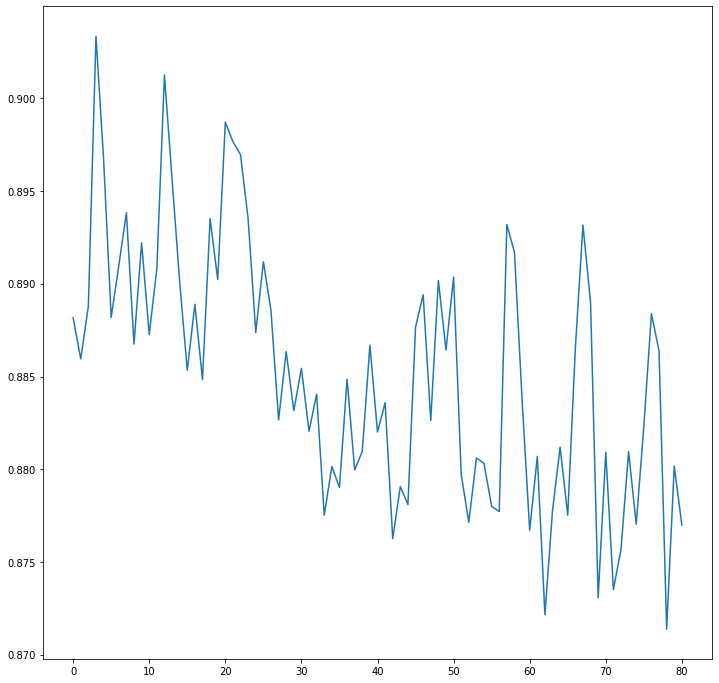

In [126]:
'''
Plot of different AUC values found
'''
plt.figure(figsize = (12, 12))
plt.plot(range(len(aucs)), aucs)
i = 0
for x in range(0, 256, step):
    #plt.axvline(x = i, linestyle = '--', color = 'gray', alpha = 0.5)
    for y in range(x, 256, step):
        i += 1

In [128]:
'''
Optimal colors approx.
'''
color_los[aucs.index(max(aucs))], color_his[aucs.index(max(aucs))]

((0, 0, 110), (55, 87, 187))